# Feature Importance 

XGBoost의 gain, cover, weight 방법과 Shap을 사용하여 특성 중요도 계산

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.utils import shuffle, resample
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

def make_train_dataset(X_train, seed):
    # upsampling abnormal data
    X_train_normal = X_train[X_train.Class==0]
    X_train_abnormal = X_train[X_train.Class==1]
    
    X_abnormal_res = resample(X_train_abnormal, replace=True, n_samples=X_train_normal.shape[0], random_state=seed)
    X_train = pd.concat([X_train_normal, X_abnormal_res])
    
    y_train = X_train.Class
    X_train = X_train.drop('Class', axis=1)
    
    # shuffle 
    X_res, y_res = shuffle(X_train, y_train, random_state=seed)
    
    return X_res, y_res


# 데이터 불러오기 및 전처리
data = pd.read_csv('./creditcard.csv')
data.drop(['Time'], axis=1, inplace=True)
X_train, X_test = train_test_split(data, stratify=data.Class, test_size=0.25, random_state=21)

ss = StandardScaler()
X_train['Amount'] = ss.fit_transform(X_train['Amount'].values.reshape(-1, 1))
X_test['Amount'] = ss.transform(X_test['Amount'].values.reshape(-1, 1))

y_test = X_test.Class
X_test = X_test.drop('Class', axis=1)
    
# 특성 중요도를 저장할 데이터프레임 초기화
importances_gain = pd.DataFrame()
importances_cover = pd.DataFrame()
importances_weight = pd.DataFrame()

# XGBoost 모델을 50번 실행
n_iter = 50
for seed in tqdm(range(n_iter)):
    # 업샘플링 
    X_res, y_res = make_train_dataset(X_train, seed)
    
    model = XGBClassifier(seed=seed)
    model.fit(X_res, y_res)

    # 각 방식으로 특성 중요도 계산 및 누적
    gain = model.get_booster().get_score(importance_type='gain')
    cover = model.get_booster().get_score(importance_type='cover')
    weight = model.get_booster().get_score(importance_type='weight')

    importances_gain = pd.concat([importances_gain, pd.Series(gain)], axis=1)
    importances_cover = pd.concat([importances_cover, pd.Series(cover)], axis=1)
    importances_weight = pd.concat([importances_weight, pd.Series(weight)], axis=1)

# 스케일링
mm_gain = MinMaxScaler()
mm_cover = MinMaxScaler()
mm_weight = MinMaxScaler()

importances_gain.columns = range(n_iter)
importances_cover.columns = range(n_iter)
importances_weight.columns = range(n_iter)

importances_gain.iloc[:, :] = mm_gain.fit_transform(importances_gain)
importances_cover.iloc[:, :] = mm_cover.fit_transform(importances_cover)
importances_weight.iloc[:, :] = mm_weight.fit_transform(importances_weight)

100%|██████████| 50/50 [02:15<00:00,  2.70s/it]


In [3]:
importances_gain.mean(axis=1).sort_values(ascending=False)

V14       1.000000
V4        0.140872
V12       0.065497
V8        0.058533
V20       0.052636
Amount    0.034615
V26       0.033943
V15       0.031450
V7        0.024868
V13       0.021092
V23       0.019597
V17       0.019011
V3        0.018124
V11       0.013852
V10       0.013627
V28       0.013273
V6        0.013237
V27       0.012142
V9        0.009346
V25       0.007550
V22       0.006950
V18       0.006785
V1        0.006612
V24       0.005695
V19       0.004592
V21       0.003537
V2        0.003349
V16       0.003033
V5        0.001981
dtype: float64

In [4]:
importances_gain.std(axis=1)[importances_gain.mean(axis=1).sort_values(ascending=False).index]

V14       9.248081e-17
V4        1.215606e-02
V12       5.937497e-03
V8        6.204108e-03
V20       7.204414e-03
Amount    6.228094e-03
V26       5.309704e-03
V15       6.866698e-03
V7        4.714060e-03
V13       5.209328e-03
V23       5.987584e-03
V17       6.882339e-03
V3        3.894141e-03
V11       3.977372e-03
V10       5.814304e-03
V28       3.679117e-03
V6        5.461290e-03
V27       3.751609e-03
V9        4.411190e-03
V25       4.748616e-03
V22       2.940934e-03
V18       3.185268e-03
V1        2.563468e-03
V24       2.809936e-03
V19       2.778194e-03
V21       2.409855e-03
V2        2.641923e-03
V16       2.971319e-03
V5        2.721309e-03
dtype: float64

In [5]:
importances_cover.mean(axis=1).sort_values(ascending=False)

V14       0.999279
V4        0.785233
V20       0.570864
V10       0.491770
V12       0.440515
V1        0.385727
V11       0.378506
V7        0.332611
V18       0.212428
V15       0.177791
V8        0.139643
Amount    0.138423
V3        0.123354
V17       0.116669
V26       0.113668
V23       0.107747
V13       0.087814
V22       0.073875
V19       0.049392
V25       0.045925
V6        0.044511
V24       0.039594
V16       0.039149
V27       0.030400
V28       0.021876
V5        0.018048
V9        0.012813
V2        0.010532
V21       0.009083
dtype: float64

In [6]:
importances_cover.std(axis=1)[importances_cover.mean(axis=1).sort_values(ascending=False).index]

V14       0.004525
V4        0.081300
V20       0.086927
V10       0.062510
V12       0.043020
V1        0.077098
V11       0.065295
V7        0.048382
V18       0.058685
V15       0.063556
V8        0.019694
Amount    0.024432
V3        0.058560
V17       0.039703
V26       0.039073
V23       0.047681
V13       0.041235
V22       0.029871
V19       0.036039
V25       0.032839
V6        0.018077
V24       0.017102
V16       0.017802
V27       0.012104
V28       0.015712
V5        0.014744
V9        0.012096
V2        0.009057
V21       0.013646
dtype: float64

In [7]:
importances_weight.mean(axis=1).sort_values(ascending=False)

V14       1.000000
V4        0.691679
V12       0.605648
V16       0.407311
Amount    0.359692
V11       0.358107
V26       0.340390
V10       0.330141
V1        0.315578
V7        0.302276
V24       0.283053
V27       0.277086
V17       0.246493
V3        0.231677
V8        0.208327
V18       0.204908
V15       0.189240
V28       0.187700
V13       0.153383
V22       0.148970
V21       0.137609
V9        0.128691
V6        0.117460
V25       0.113557
V19       0.103841
V2        0.100728
V20       0.098865
V23       0.074886
V5        0.044395
dtype: float64

In [8]:
importances_weight.std(axis=1)[importances_weight.mean(axis=1).sort_values(ascending=False).index]

V14       9.647461e-17
V4        1.005555e-01
V12       7.998445e-02
V16       7.247836e-02
Amount    7.550872e-02
V11       8.010728e-02
V26       9.189659e-02
V10       8.598890e-02
V1        8.650931e-02
V7        7.145873e-02
V24       7.387218e-02
V27       7.257035e-02
V17       7.879161e-02
V3        8.053260e-02
V8        5.380300e-02
V18       7.140795e-02
V15       6.774815e-02
V28       6.927779e-02
V13       7.011078e-02
V22       7.310153e-02
V21       6.452240e-02
V9        7.644891e-02
V6        7.160239e-02
V25       8.443883e-02
V19       7.655191e-02
V2        5.859648e-02
V20       6.751995e-02
V23       6.535897e-02
V5        5.528496e-02
dtype: float64

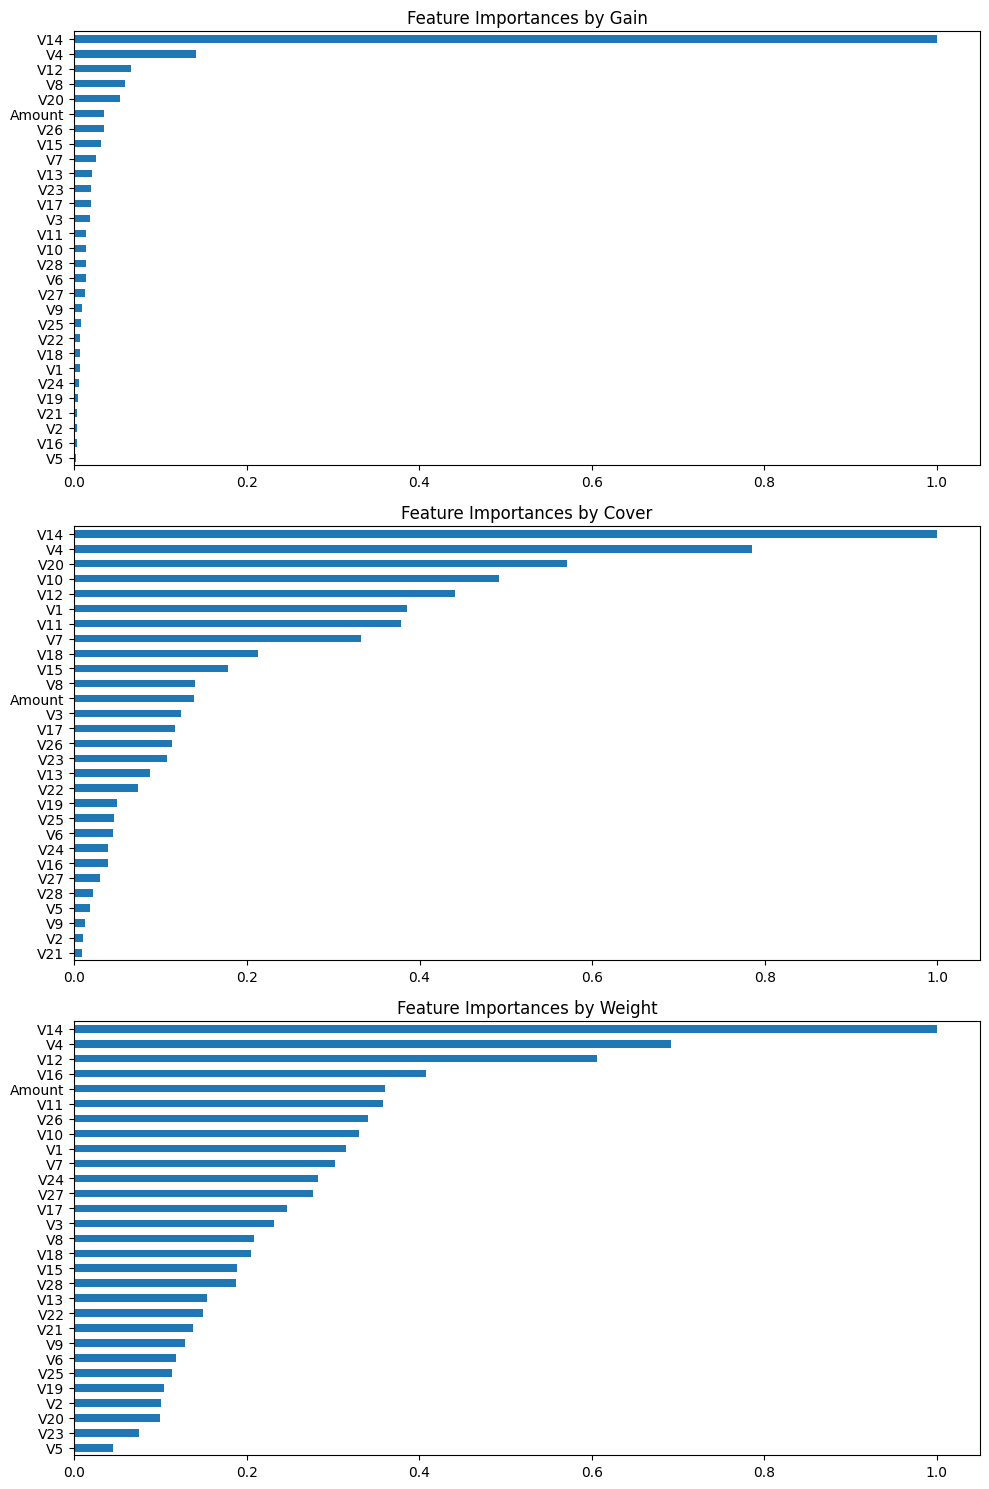

In [9]:
# 특성 중요도 시각화
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

importances_gain.mean(axis=1).sort_values(ascending=True).plot(kind='barh', ax=axes[0], title='Feature Importances by Gain')
importances_cover.mean(axis=1).sort_values(ascending=True).plot(kind='barh', ax=axes[1], title='Feature Importances by Cover')
importances_weight.mean(axis=1).sort_values(ascending=True).plot(kind='barh', ax=axes[2], title='Feature Importances by Weight')

plt.tight_layout()
plt.show()

In [10]:
X_test

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
96454,-0.663214,1.199141,1.456688,-0.080417,-0.086426,-0.913008,0.713641,-0.071381,-0.241148,-0.011890,...,0.246264,-0.254638,-0.598495,-0.006621,0.363830,-0.131162,0.075334,0.371379,0.188413,-0.316150
244883,2.034072,-0.906549,-1.813553,-0.673499,-0.353377,-1.394044,0.200283,-0.548179,-0.664934,0.741156,...,0.167161,0.290907,0.759791,-0.100595,0.065713,0.325009,-0.006547,-0.071256,-0.057869,0.109389
17804,-1.963862,-4.756226,-2.409636,2.379289,-0.831642,0.843814,2.337278,-0.441272,-0.292421,-1.313424,...,3.383859,0.819160,-1.328590,-1.650314,-1.347640,0.034053,-0.512975,-0.257299,0.330680,6.259561
274561,0.271639,1.518904,-1.501511,-0.189177,1.755633,-1.044843,1.272126,-0.372402,-0.366270,-1.732855,...,0.047148,0.217151,0.893864,-0.339029,-1.173916,-0.680399,-0.172130,0.315107,0.319426,-0.343651
221455,-2.262296,0.212430,0.222364,-2.522262,0.049222,-0.211146,-0.333198,1.013773,-1.678439,-0.222761,...,0.160270,-0.269612,-1.060972,0.215608,0.035022,0.644898,-0.627333,0.238077,-0.249116,-0.324058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129139,-0.032339,0.199157,2.259708,1.246952,-0.698531,-0.077375,-0.212392,0.022700,0.650712,0.120052,...,0.139382,0.000424,0.319766,0.055413,0.402556,-1.089290,0.403559,0.052300,-0.021888,-0.313160
211962,-0.293636,1.155012,-0.091555,-0.582666,0.971411,-0.819777,1.019648,-0.146519,-0.155418,-0.820596,...,0.042726,-0.339664,-0.884527,-0.028597,0.638998,-0.153526,0.161485,0.102369,0.104963,-0.324019
37396,0.456481,-2.325811,0.560286,-0.169874,-1.872457,0.329824,-0.662988,0.128498,-0.089048,0.355338,...,0.953448,0.298396,-0.036834,-0.435132,0.056349,0.217961,-0.288009,-0.037697,0.088825,1.451985
53942,-0.116912,1.314720,1.040745,2.814085,0.834502,-0.374678,0.848516,-0.192715,-1.842909,0.772690,...,0.188104,0.067617,0.197258,-0.237899,0.066379,0.129748,0.296777,0.042600,0.045275,-0.344202


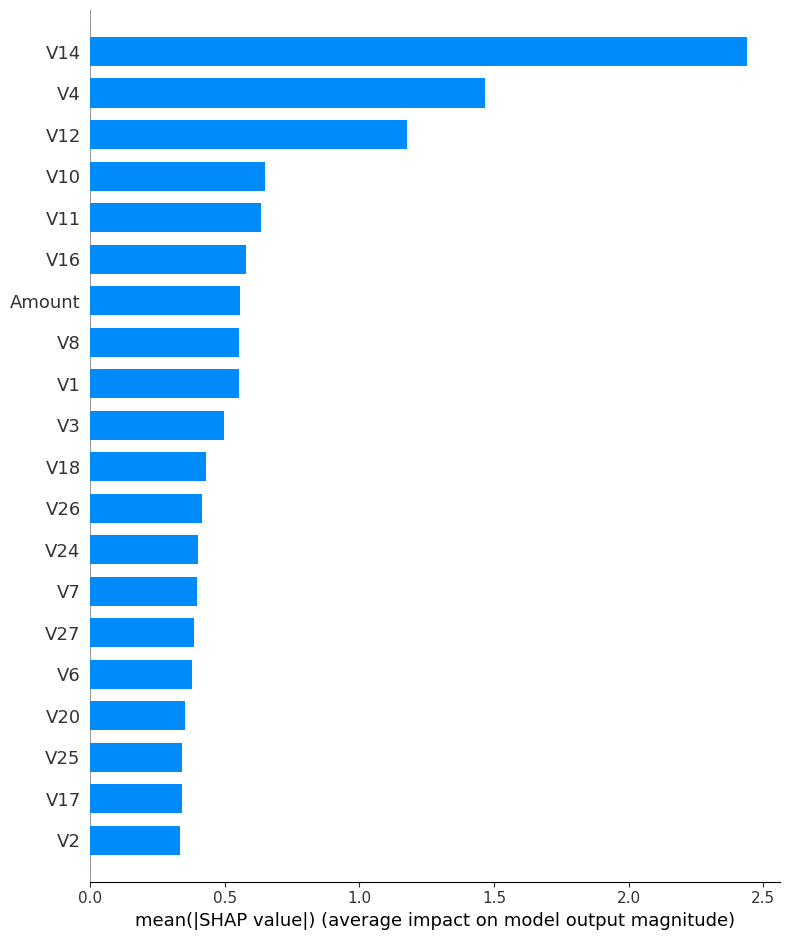

In [15]:
import shap

# SHAP를 계산하기 위해 마지막 XGBoost 모델 사용
shap_explainer = shap.TreeExplainer(model)
shap_values = shap_explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")